# Indeed Job Scraper and Word Cloud Generator

The following scrapes Indeed.com for job information that correspondings to a query term `q` and location `l`. Passing both of these terms to `scrape_jobs(q,l)` returns the job title, company, posting url, and description in the form of a `dict`.

This dictionary can easily be imported to a `pandas` dataframe, which can then be passed to `draw_cloud(df)` to produce the word cloud.

## Import necessary packages

In [2]:
from bs4 import BeautifulSoup
import requests
from time import sleep
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from stop_words import get_stop_words

%matplotlib notebook


## Anonymous Functions

These functions are defined to make querying easier.


In [3]:
# Some base urls
base_url = 'https://www.indeed.com'

# Some anonymous functions
query = lambda x: "-".join(x.lower().split(" "))
get_search_url = lambda q,l: 'https://www.indeed.com/q-"{}"-l-{}-jobs.html'.format(query(q),query(l))
get_pagination = lambda soup: soup.find("div",attrs={'class':'pagination'})
get_no_jobs = lambda soup: int("".join(soup.find("div",attrs={"id": "searchCount"}).text.split()[-2].split(",")))
get_next_page = lambda pagination: next_page_base_url + pagination.findChild("a")['href']
get_jobs = lambda soup: soup.findAll("div",attrs={'class':'jobsearch-SerpJobCard'})
get_more_jobs = lambda pagination: pagination.findChildren("a")[-1].findChild(attrs={'class':'pn'}).text
get_next_page = lambda pagination: base_url + pagination.findChildren("a")[-1]['href']
move_on = lambda pagination: 'Next' in get_more_jobs(pagination)
get_title = lambda job: job.findChild(attrs={'class':'title'}).text.strip()
get_job_url = lambda x: base_url+x.find("a",attrs={'class':'jobtitle turnstileLink '})['href']
find_child_by_class = lambda soup,type,cl: soup.findChild(type,{'class':cl})

## Main Functionality 

These are the main tasks to be used.

In [4]:
# Main functionality

def get_soup(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text,'html.parser')
    pagination = get_pagination(soup)
    
    return soup,pagination

def find_all_jobs(q,l):
    print("Finding all {} jobs in {}...".format(q,l))
    soup, pagination = get_soup(get_search_url(q,l))
    jobs = []
    _ = [jobs.append(i) for i in get_jobs(soup)]
    
    while move_on(pagination):
        soup, pagination = get_soup(get_next_page(pagination))
        _ = [jobs.append(i) for i in get_jobs(soup)]
        #sleep(0.1)

    return jobs

def extract_job_details(jobs):
    print("\tScraping job details...")
    job_entries = {}
    
    for i,job in enumerate(jobs):
        soup,pagination = get_soup(get_job_url(job))
        title = get_title(job)
        url = get_job_url(job)
        job_header = find_child_by_class(soup,"div","jobsearch-DesktopStickyContainer")
        try:
            company = find_child_by_class(job_header,"div","jobsearch-DesktopStickyContainer-companyrating").findChild("a").text
        except:
            company = "None"
        description = find_child_by_class(soup,"div","jobsearch-jobDescriptionText").text
        
        job_entry = {'company': company, 'title': title, 'url': url, 'description': description}
        job_entries[url] = job_entry

        #sleep(0.1)
        
    return job_entries

def scrape_jobs(q,l):
    jobs = find_all_jobs(q,l)
    job_details = extract_job_details(jobs)
    print("\t\t...Done!")
    return job_details

def draw_wordcloud(df,column="description"):
    text = []
    _ = [text.append(i+" ") for i in df[column]]
    text = [i.lower() for i in text]
    
    my_stopwords = set(STOPWORDS)
    extra_stopwords = ["experience","position","work","please","click","must","may","required","preferred", 
                        "type","including","strong","ability","needs","apply","skills","requirements","company", 
                        "knowledge","job","responsibilities","customer","year","data","will","product","team",
                        "analytic","analytics","business","working","engineer","engineering","using","years","service","build",
                        "design","support","new","environment","project","technology","management","customers","tool",
                        "solution","solutions","analysis","technical","tools","teams","help","provide","information","platform",
                        "looking","Develop","time","application","member","partner","best","big","plus","model","etc",
                        "qualification","deliver","us","system",""]
    _ = [my_stopwords.add(i) for i in get_stop_words('en')]
    _ = [my_stopwords.add(i) for i in extra_stopwords]
    _ = [my_stopwords.add(i) for i in [i+"s" for i in extra_stopwords]]
    _ = [my_stopwords.add(i) for i in [i.upper() for i in extra_stopwords]]

    wordcloud = WordCloud(background_color="white", max_words=200, stopwords=my_stopwords, \
                          contour_width=3, contour_color='steelblue').generate(" ".join(text))


    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

## Example

In the following example, jobs matching the search terms "Data Scientist", "Data Engineer", and "Data Analyst" in Portland are scraped. Word clouds are then drawn based on all the job descriptions for each search term, as well as for the combined job descriptions of all three terms.

In [5]:
 
search_criteria = [
    ["Data Engineer","Portland"],
    ["Data Scientist","Portland"],
    ["Data Analyst","Portland"],
]

searches = {}

for i,j in search_criteria:
    searches[i] = scrape_jobs(i,j)

Finding all Data Engineer jobs in Portland...
	Scraping job details...
		...Done!
Finding all Data Scientist jobs in Portland...
	Scraping job details...
		...Done!
Finding all Data Analyst jobs in Portland...
	Scraping job details...
		...Done!


### Draw Word Cloud for Each Search Term Based on Descriptions

<IPython.core.display.Javascript object>


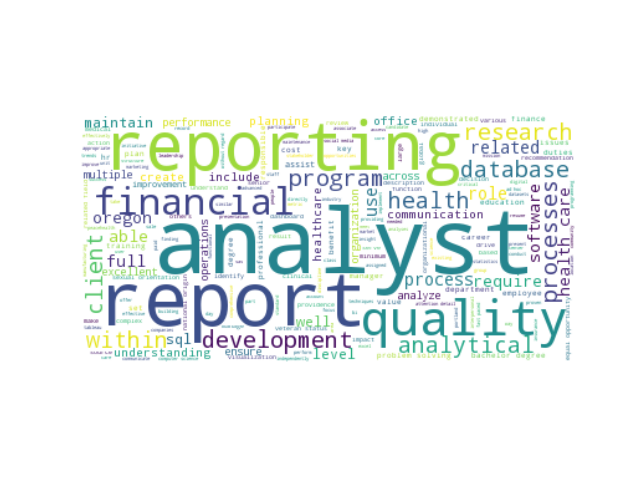

<IPython.core.display.Javascript object>


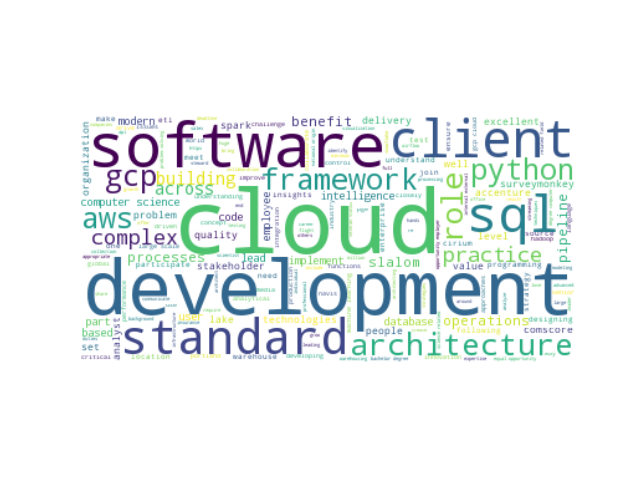

<IPython.core.display.Javascript object>


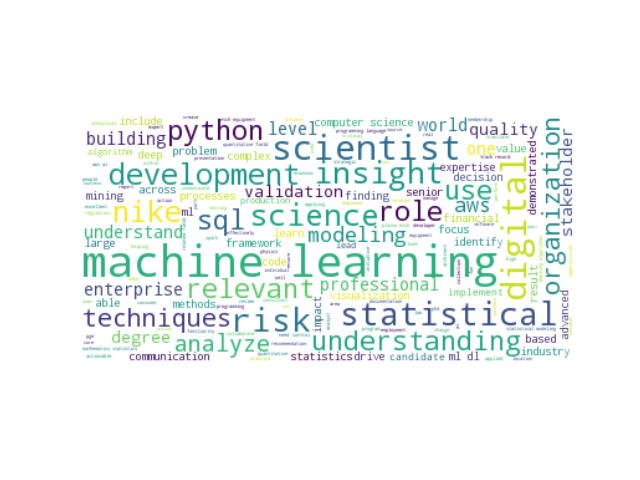

In [6]:
ds = [pd.DataFrame.from_dict(searches[i],orient='index') for i in searches.keys()]
_ = [draw_wordcloud(frame) for frame in ds]

### Draw Word Cloud for combined Descriptions

<IPython.core.display.Javascript object>


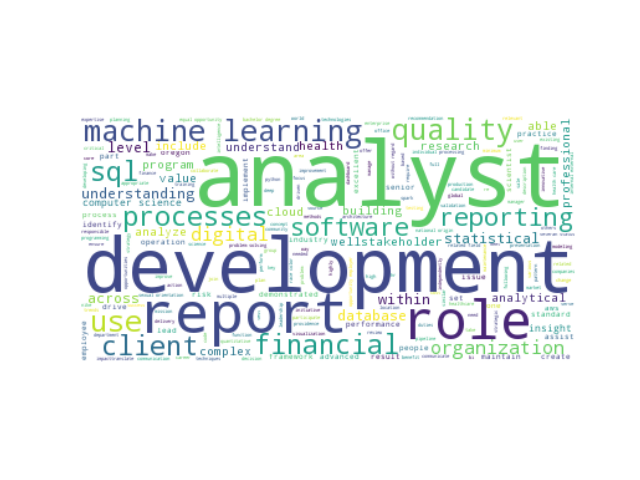

In [7]:
d_joined = pd.concat([d for d in ds])
draw_wordcloud(d_joined)

### Draw Word Cloud for Combined Job Titles

<IPython.core.display.Javascript object>


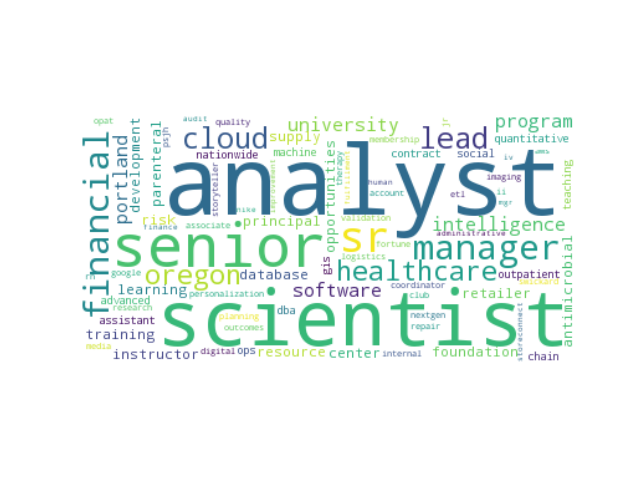

In [8]:
draw_wordcloud(d_joined,column="title")